In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import os
import tensorflow as tf
import shap
import seaborn as sns
from sklearn import preprocessing
import tensorflow.keras.layers as tfl
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from os import walk
for (dirpath, dirnames, filenames) in walk("./DATASET"):
    print("Directory path: ", dirpath)

Directory path:  ./DATASET
Directory path:  ./DATASET/TEST
Directory path:  ./DATASET/TEST/downdog
Directory path:  ./DATASET/TEST/goddess
Directory path:  ./DATASET/TEST/plank
Directory path:  ./DATASET/TEST/tree
Directory path:  ./DATASET/TEST/warrior2
Directory path:  ./DATASET/TRAIN
Directory path:  ./DATASET/TRAIN/downdog
Directory path:  ./DATASET/TRAIN/goddess
Directory path:  ./DATASET/TRAIN/plank
Directory path:  ./DATASET/TRAIN/tree
Directory path:  ./DATASET/TRAIN/warrior2


In [2]:
#!pip install shap

In [3]:
train_path = "./DATASET/TRAIN"
test_path = "./DATASET/TEST"

## Data Preprocessing

### Histogram Equalization 
Histogram Equalization is used for improving the contrast of any image, that is- to make the dark portion darker and the bright portion brighter.
For a grey-scale image, each pixel is represented by the intensity value (brightness); that is why we can feed the pixel values directly to the HE function. However, that is not how it works for an RGB-formatted color image. Each channel of the R, G, and B represents the intensity of the related color, not the intensity/brightness of the image as a whole. And so, running HE on these color channels is NOT the proper way.
We should first separate the brightness of the image from the color and then run HE on the brightness. Now, there are already standardized colorspaces that encode brightness and color separately, like- YCbCr, HSV, etc.; so, we can use them here for separating and then re-merging the brightness

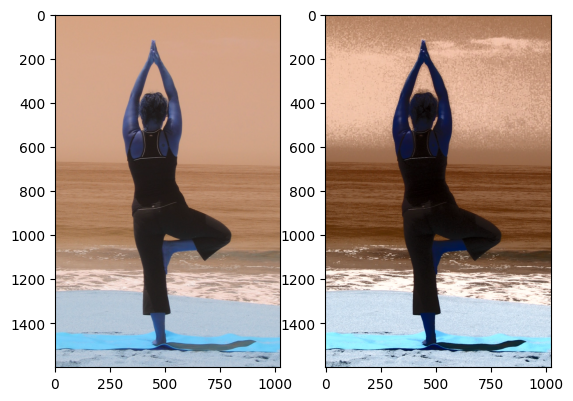

In [4]:
bgr_img = cv2.imread(train_path+'/tree/00000070.jpg')

# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCrCb)
 # equalize the histogram of the Y channel
ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

plt.subplot(121),plt.imshow(bgr_img)

plt.subplot(122),plt.imshow(equalized_img)
plt.show()

### CLAHE (Contrast Limited Adaptive Histogram Equalization)
#### Now the input image’s contrast has improved significantly but at the expense of also boosting the contrast of the noise in the input image. We can solve this problem by using adaptive histogram equalization 

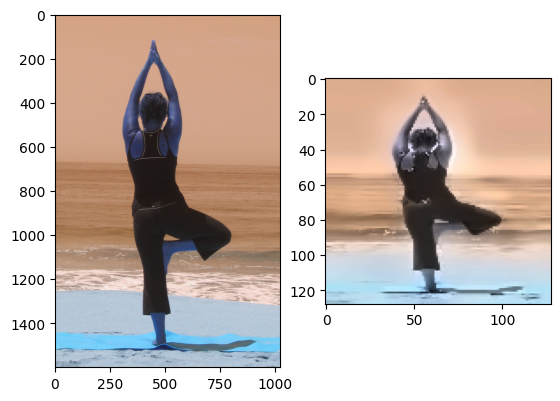

In [5]:
bgr_img = cv2.imread(train_path+'/tree/00000070.jpg')
# dsize
dsize = (128,128)
resized_image = cv2.resize(bgr_img,dsize)
# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
# create a CLAHE object 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Now apply on the YCrCb image 
ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

# Denoise is done to remove unwanted noise to better perform
equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)

plt.subplot(121),plt.imshow(bgr_img)
plt.subplot(122),plt.imshow(equalized_denoised_image)
plt.show()



In [6]:
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            bgr_img = cv2.imread(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = cv2.resize(bgr_img,dsize)
            # convert from BGR color-space to YCrCb
            ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
            # create a CLAHE object 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # Now apply CLAHE object on the YCrCb image
            ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
            # convert back to BGR color-space from YCrCb
            equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
            # Denoise is done to remove unwanted noise to better perform
            equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
            
            images_data.append(equalized_denoised_image/255)
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label

In [7]:
train_images_data, train_images_label = preprocess_images(train_path)

Corrupt JPEG data: premature end of data segment
Premature end of JPEG file


In [8]:
def encoding_targets(labels):
    le = preprocessing.LabelEncoder()
    images_label = le.fit_transform(labels)
    return images_label

In [9]:
class_names = os.listdir(train_path)
class_num = len(class_names)
train_images_label = encoding_targets(train_images_label)

## CNN Model Development

In [10]:

model = tf.keras.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
        
    
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),    
        
    
        tfl.Flatten(),
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
    
        tfl.Dense(class_num, activation='softmax')
        
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 29, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0

In [11]:
epochs = 20
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training Model

### K-fold Cross validation

In [12]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True,random_state=2)

In [13]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_images_data[train], train_images_label[train], batch_size=16, 
                        epochs=epochs, validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
54/54 [==============================] - 3s 47ms/step - loss: 2.1008 - accuracy: 0.4537 - val_loss: 1.6764 - val_accuracy: 0.3687
Epoch 2/20
54/54 [==============================] - 2s 42ms/step - loss: 0.8974 - accuracy: 0.6933 - val_loss: 1.5699 - val_accuracy: 0.2535
Epoch 3/20
54/54 [==============================] - 2s 42ms/step - loss: 0.7102 - accuracy: 0.7465 - val_loss: 2.5209 - val_accuracy: 0.2673
Epoch 4/20
54/54 [==============================] - 2s 42ms/step - loss: 0.4718 - accuracy: 0.8356 - val_loss: 2.2155 - val_accuracy: 0.2074
Epoch 5/20
54/54 [==============================] - 2s 41ms/step - loss: 0.2825 - accuracy: 0.8970 - val_loss: 2.2119 - val_accuracy: 0.2488
Epoch 6/20
54/54 [=====

In [14]:
print(f'> Mean_Training_Accuracy: {np.mean(acc_per_fold)*100} (+- {np.std(acc_per_fold)})')
print(f'> Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100} (+- {np.std(val_acc_per_fold)})')

> Mean_Training_Accuracy: 96.75260895490646 (+- 0.0675617928751207)
> Mean_Validation_Accuracy: 89.77366085350513 (+- 0.2004904861805918)


## Evaluation and Optimization

### Overfitting Issue
#### > Training_Accuracy: 94.34937888383865 (+- 0.10064080565561062)
#### > Validation_Accuracy: 86.20323440432549 (+- 0.23861513322009303)


### Data Augmentation
#### So far we are working human postures and the flip of postures can change the definition of yoga poses. As a result model emits poor result when flip(horizontal_flip, vertical_flip) parameters are passed True.


In [15]:
dataAugmentaion = ImageDataGenerator(rotation_range = 10, zoom_range = 0.30, 
                                        fill_mode = "nearest", shear_range = 0.30)

In [16]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit_generator(dataAugmentaion.flow(train_images_data[train], train_images_label[train], batch_size=16),
                                  epochs=epochs,
                                  validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
54/54 [==============================] - 2s 46ms/step - loss: 1.4792 - accuracy: 0.6863 - val_loss: 0.1536 - val_accuracy: 0.9493
Epoch 2/20
54/54 [==============================] - 2s 45ms/step - loss: 1.0850 - accuracy: 0.7141 - val_loss: 0.3719 - val_accuracy: 0.8802
Epoch 3/20
54/54 [==============================] - 2s 46ms/step - loss: 0.8258 - accuracy: 0.7477 - val_loss: 0.0222 - val_accuracy: 0.9954
Epoch 4/20
54/54 [==============================] - 2s 46ms/step - loss: 0.8215 - accuracy: 0.7616 - val_loss: 0.0989 - val_accuracy: 0.9770
Epoch 5/20
54/54 [==============================] - 2s 46ms/step - loss: 0.7222 - accuracy: 0.7755 - val_loss: 0.6328 - val

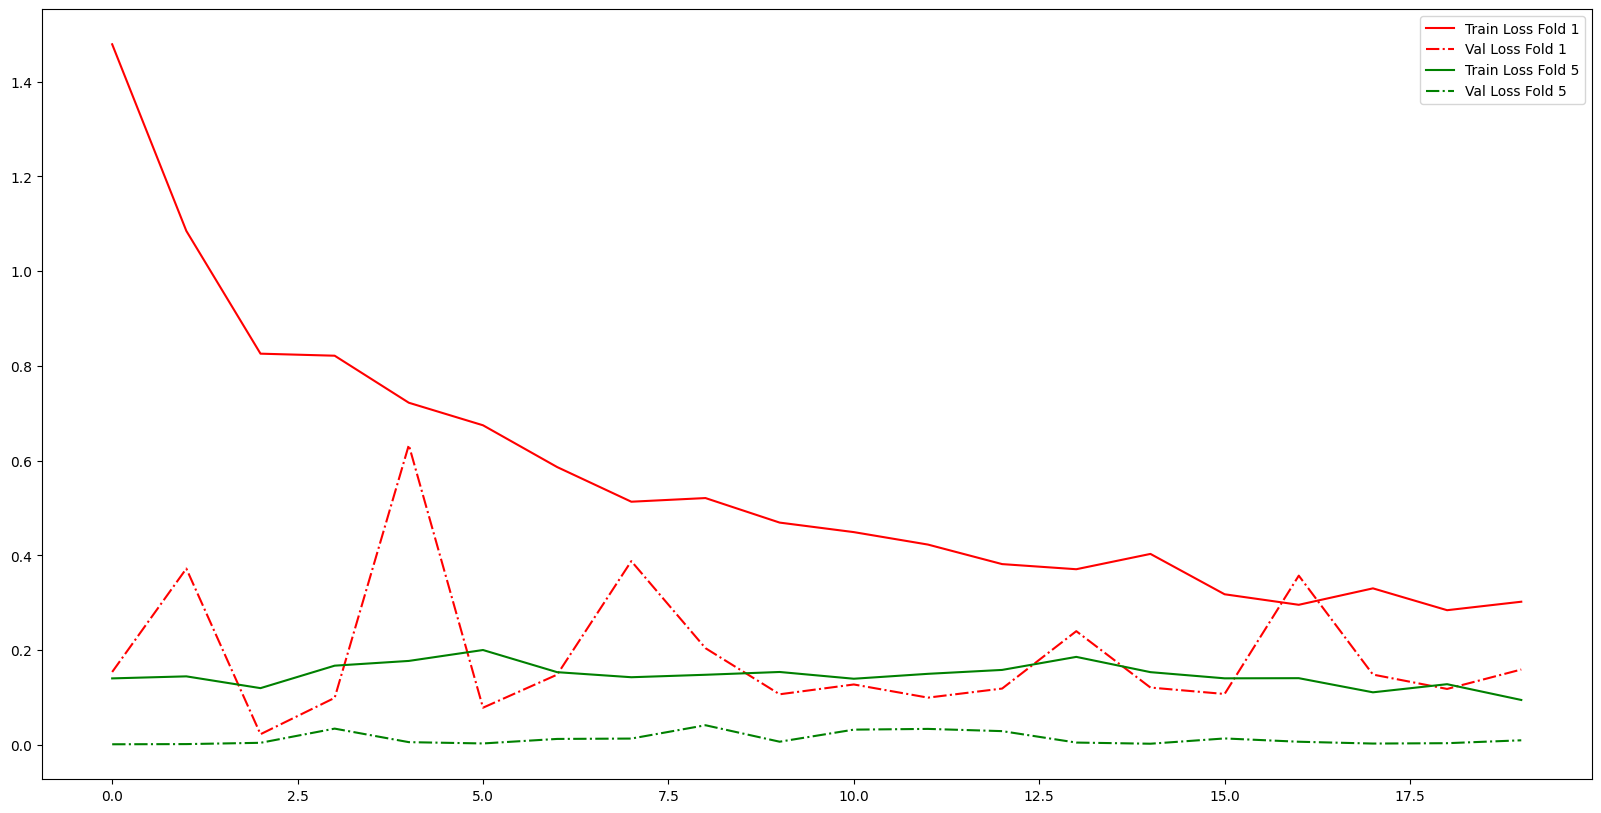

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(loss_per_fold[0], label='Train Loss Fold 1', color='red')
plt.plot(val_loss_per_fold[0], label='Val Loss Fold 1', color='red', linestyle = "dashdot")
plt.plot(loss_per_fold[4], label='Train Loss Fold 5', color='green')
plt.plot(val_loss_per_fold[4], label='Val Loss Fold 5', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [18]:
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test Data accuracy:  90.2127659574468

Confusion Matrix : 
[[ 88   0   5   3   1]
 [  1  64   5   4   6]
 [  3   2 104   1   5]
 [  0   1   0  68   0]
 [  0   5   1   3 100]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.96      0.91      0.93        97
     goddess       0.89      0.80      0.84        80
       plank       0.90      0.90      0.90       115
        tree       0.86      0.99      0.92        69
    warrior2       0.89      0.92      0.90       109

    accuracy                           0.90       470
   macro avg       0.90      0.90      0.90       470
weighted avg       0.90      0.90      0.90       470



#### From heatmap visualization we can see a lot of goddess images were predicted as warrior2

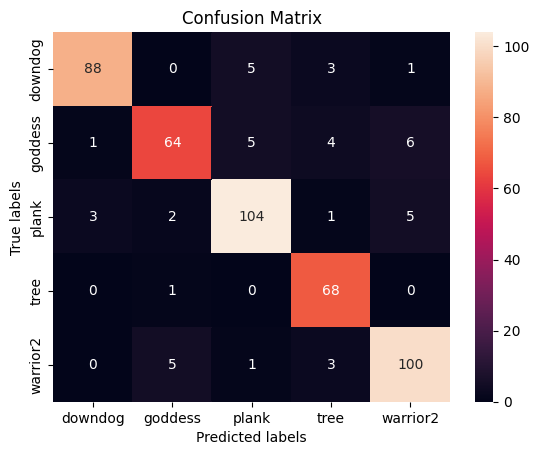

In [19]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);

## Visualize Model
#### The chart shows the actual image and parts of it highlighted in shades of red and blue colors. The shades of red color show parts that contributed positively and shades of blue color show parts that contributed negatively to the prediction of that category.

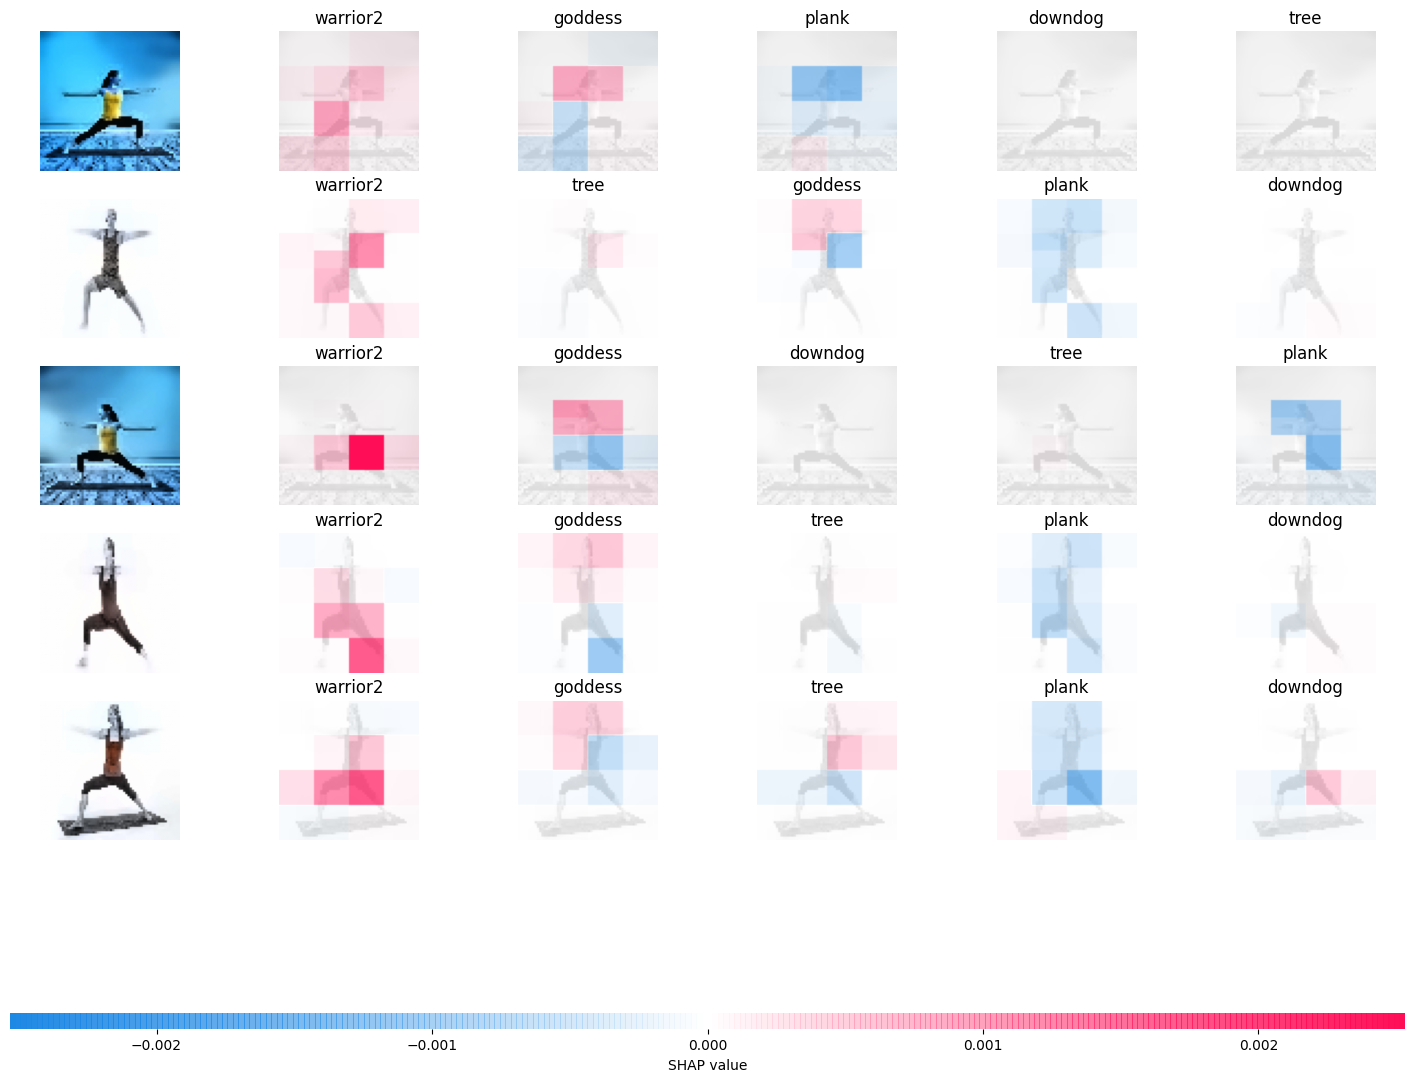

In [20]:
shap.initjs()
#Masker to mask parts of an image using blurring
masker = shap.maskers.Image("blur(64,64)", train_images_data[0].shape)
#Explainer() constructor by default creates an instance of Partition explainer
explainer = shap.Explainer(model, masker, output_names=class_names)
#generate shap values for images using the explainer object
shap_values = explainer(test_images_data[361:366], outputs=shap.Explanation.argsort.flip[:5])
shap.image_plot(shap_values)